In [1]:
from gudhi import CoverComplex
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In this notebook, we will see how to use Gudhi in order to perform topological dimension reduction: we will compute simplicial complex approximations of point cloud / distance matrices. These complexes will be either [Mapper complexes](https://diglib.eg.org/handle/10.2312/SPBG.SPBG07.091-100) or [Graph Induced complexes](http://web.cse.ohio-state.edu/~dey.8/GIC/gic.html). Both complexes use covers of the initial space (such as Voronoi partitions or preimages of filter functions), and use these covers to generate simplicial complexes, either by taking the nerve (Mapper) or by checking the presence of colored cliques (Graph Induced). 

Gudhi can handle both point clouds and distance matrices. Let's start with a point cloud.

# Point cloud

Load an example point cloud.

In [2]:
X = np.loadtxt('/home/mathieu/Documents/code/gudhi/data/points/human.txt')

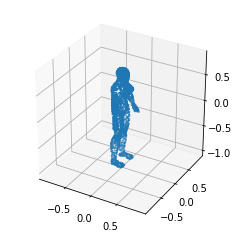

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')
ax.scatter(X[::2,1], X[::2,0], X[::2,2], s=1)
limits = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
origin = np.mean(limits, axis=1)
radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
x, y, z = origin
ax.set_xlim3d([x - radius, x + radius])
ax.set_ylim3d([y - radius, y + radius])
ax.set_zlim3d([z - radius, z + radius])
plt.show()

We will use the height function to color the complex nodes.

In [4]:
height = X[:,2]

We next provide different configurations for computing cover complexes:

Graph Induced complex with a Voronoi partition with 100 randomly sampled germs and Rips graph obtained with automatic threshold. 

In [ ]:
cover_complex = CoverComplex(
    complex_type='gic', input_type='point cloud', cover='voronoi', colors=height, mask=0,
    graph="rips", rips_threshold=None, N=100, beta=0., C=10,
    voronoi_samples=100, 
    input_name="human", cover_name="coord2", color_name="coord2", verbose=True)

Graph Induced complex with a preimage partition with automatic resolution and Rips graph obtained with automatic threshold. 

In [ ]:
cover_complex = CoverComplex(
    complex_type='gic', input_type='point cloud', cover='functional', colors=height, mask=0,
    graph="rips", rips_threshold=None, N=100, beta=0., C=10,
    filters=height, resolutions=None, gains=0.,
    input_name="human", cover_name="coord2", color_name="coord2", verbose=True)

Mapper complex with a preimage cover with automatic resolution and hierarchical clustering obtained with automatic threshold. 

In [5]:
cover_complex = CoverComplex(
    complex_type='mapper', input_type='point cloud', cover='functional', colors=height[:,np.newaxis], mask=0,
    clustering=None, N=100, beta=0., C=10,
    filters=height[:,np.newaxis], filter_bnds=None, resolutions=None, gains=None,
    input_name="human", cover_name="coord2", color_name="coord2", verbose=True)

Mapper complex with a preimage cover with automatic resolution from a 2D function and hierarchical clustering obtained with automatic threshold. 

In [ ]:
filt2d = np.hstack([height[:,np.newaxis],X[:,0:1]])

In [ ]:
cover_complex = CoverComplex(
    complex_type='mapper', input_type='point cloud', cover='functional', colors=filt2d, mask=0,
    clustering=None, N=100, beta=0., C=10,
    filters=filt2d, filter_bnds=None, resolutions=[20,2], gains=None,
    input_name="human", cover_name="coord2", color_name="coord2", verbose=True)

# Distance matrix

We can actually process the dataset using only the pairwise distances between points.

In [ ]:
from sklearn.metrics import pairwise_distances

In [ ]:
X = pairwise_distances(X)

In [ ]:
plt.figure()
plt.imshow(X)
plt.show()

This time, color is given by eccentricity.

In [ ]:
ecc = X.max(axis=0)

In [ ]:
cover_complex = CoverComplex(
    complex_type='gic', input_type='distance matrix', cover='functional', colors=ecc, mask=0,
    graph="rips", rips_threshold=None, N=100, beta=0., C=10,
    filters=ecc, resolutions=None, gains=0.,
    input_name="human", cover_name="coord2", color_name="coord2", verbose=True)

In [ ]:
cover_complex = CoverComplex(
    complex_type='gic', input_type='distance matrix', cover='voronoi', colors=ecc, mask=0,
    graph="rips", rips_threshold=None, N=100, beta=0., C=10,
    voronoi_samples=100, 
    input_name="human", cover_name="coord2", color_name="coord2", verbose=True)

In [ ]:
cover_complex = CoverComplex(
    complex_type='mapper', input_type='distance matrix', cover='functional', colors=ecc[:,np.newaxis], mask=0,
    clustering=None, N=100, beta=0., C=10,
    filters=ecc[:,np.newaxis], filter_bnds=None, resolutions=None, gains=None,
    input_name="human", cover_name="coord2", color_name="coord2", verbose=True)

# Complex computation

The cover complex can now be computed in a single line of code!

In [6]:
_ = cover_complex.fit(X)

/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


# Visualization

You can visualize the complex in three different ways with Gudhi.

1. You can use Python package `networkx`.

In [7]:
import networkx as nx

In [8]:
G = cover_complex.get_networkx()

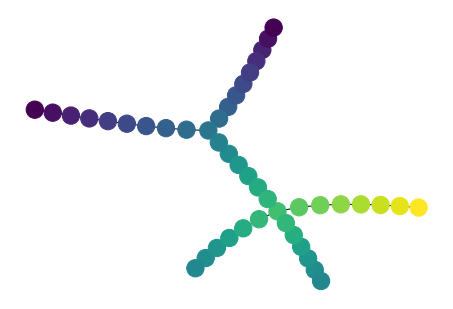

In [9]:
plt.figure()
nx.draw(G, pos=nx.kamada_kawai_layout(G), node_color=[cover_complex.node_info[v]["colors"][0] for v in G.nodes()])
plt.show()

2. You can create a DOT file that can be processed later with `neato` to produce a PDF.

In [ ]:
cover_complex.print_to_dot()

In [ ]:
!neato -Tpdf human.dot -o human.pdf 

3. You can create a TXT file that you can process later with our KeplerMapper wrapper to produce a HTML file that you can visualize in browser.

In [ ]:
cover_complex.print_to_txt()

In [ ]:
!python /home/mathieu/Documents/code/gudhi/src/Nerve_GIC/utilities/KeplerMapperVisuFromTxtFile.py -f human.txt

# Topological features

There are various postprocessing one can do on a cover complex. For instance, one can compute the topological features in the complex. For our human shape, the topological features (identified by computing the persistence of the color function on the complex) are the three branches corresponding to the arms and legs (the lower leg correspond to the whole connected component).

In [10]:
dgm, bnd = cover_complex.compute_topological_features(threshold=0.)

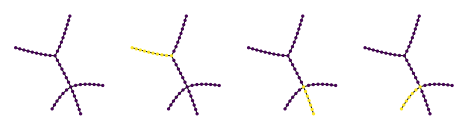

In [11]:
G = cover_complex.get_networkx()
plt.figure(figsize=(8,2))
for idx, bd in enumerate(bnd):
    plt.subplot(1,len(bnd),idx+1)
    nx.draw(G, pos=nx.kamada_kawai_layout(G), 
            node_color=[1 if node in bd else 0 for node in G.nodes()], node_size=5)
plt.show()

You can also identify the robust topological features by bootstrapping, and select those associated to 95% confidence.

In [12]:
cover_complex.bootstrap_topological_features(100)

0th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


1th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


2th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


3th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


4th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


5th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


6th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


7th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


8th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


9th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


10th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


11th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


12th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


13th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


14th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


15th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


16th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


17th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


18th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


19th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


20th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


21th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


22th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


23th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


24th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


25th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


26th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


27th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


28th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


29th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


30th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


31th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


32th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


33th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


34th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


35th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


36th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


37th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


38th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


39th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


40th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


41th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


42th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


43th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


44th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


45th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


46th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


47th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


48th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


49th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


50th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


51th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


52th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


53th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


54th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


55th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


56th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


57th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


58th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


59th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


60th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


61th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


62th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


63th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


64th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


65th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


66th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


67th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


68th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


69th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


70th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


71th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


72th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


73th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


74th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


75th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


76th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


77th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


78th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


79th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


80th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


81th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


82th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


83th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


84th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


85th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


86th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


87th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


88th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


89th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


90th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


91th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


92th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


93th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


94th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


95th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


96th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


97th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


98th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


99th iteration


/home/mathieu/Documents/python/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  """Entry point for launching an IPython kernel.


In [13]:
dist = cover_complex.get_distance_from_confidence_level(.95)

In [14]:
bnd_boot = [b for idx, b in enumerate(bnd) if np.abs(.5 * (dgm[idx][1][1]-dgm[idx][1][0])) >= dist]

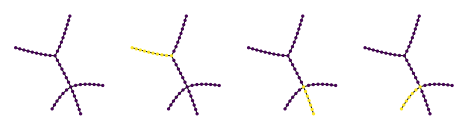

In [15]:
G = cover_complex.get_networkx()
plt.figure(figsize=(8,2))
for idx, bd in enumerate(bnd_boot):
    plt.subplot(1,len(bnd_boot),idx+1)
    nx.draw(G, pos=nx.kamada_kawai_layout(G), 
            node_color=[1 if node in bd else 0 for node in G.nodes()], node_size=5)
plt.show()

Finally, one can identify the coordinates that best explain a topological feature VS the rest of the complex with a Kolmogorov-Smirnov test. In particular, for each topological feature, we can rank the coordinates with respect to their p-values. 

For instance, coordinate 2 (height) is the one that best distinguishes the leg from the rest.

In [16]:
cover_complex.compute_differential_coordinates(nodes=bnd[1])

(array([2, 0, 1]), array([0.00000000e+000, 1.73876879e-206, 1.98551114e-027]))

On the other hand, coordinate 0 best explains both arms.

In [17]:
cover_complex.compute_differential_coordinates(nodes=bnd[2])

(array([0, 2, 1]), array([3.19690582e-165, 3.97613179e-066, 1.53419145e-022]))

In [18]:
cover_complex.compute_differential_coordinates(nodes=bnd[3])

(array([0, 2, 1]), array([1.47395919e-167, 5.74742012e-066, 1.12041777e-022]))